# ST7 Planification quotidienne d’une équipe mobile

In [1]:
# Modules de base
import pandas as pd
import numpy as np
from datetime import datetime
from math import radians, cos, sin, asin, sqrt
from utils import parse_time, parse_time_minute

import matplotlib.pyplot as plt
%matplotlib inline

# Module relatif à Gurobi
from gurobipy import *

# Utilités
from math import ceil
from utils import plot_map

In [2]:
class Employee:
    list = []  # list of all employee instances
    count = 0 # employee count, i.e. the length of Employee.list
    speed = 50 * 1000 / 60  # unit: meter/minute
    __name_employee_correspondance = {} # stores the correspondance between names and instances

    def __init__(self, name: str, latitude: float, longitude: float, skill: str, level: int, start_time, end_time):
        """
        Initialize an employee instance and store it to the list of employees
        :param name: name of the employee
        :param latitude: latitude of the employee's home
        :param longitude: longitude of the employee's home
        :param skill: the skill of the employee
        :param level: the level of the employee's skill
        :param start_time: the time at which the employee starts working
        :param end_time: the time at which the employee stops working
        """
        self.name = name
        self.latitude = latitude
        self.longitude = longitude
        self.skill = skill
        self.level = level
        self.start_time_str = parse_time(start_time)  # parse time into datetime object for printing
        self.end_time_str = parse_time(end_time)
        self.start_time = parse_time_minute(start_time)  # parse time into minutes
        self.end_time = parse_time_minute(end_time)
        self.unavails = [] # employee unavailabilities
        Employee.count += 1
        Employee.list.append(self)

    @classmethod
    def find_by_name(cls, name: str):
        """
        Find the instance of the employee from its name.
        :param name: name of the employee
        :return: the corresponding employee instance
        """
        for employee in cls.list:
            if employee.name == name:
                return employee

    @classmethod
    def load_excel(cls, path) -> None:
        """
        Load all employee data.
        :param path: path of the Excel file storing data about the city instance
        """

        # clear previously loaded data if any
        if cls.count:
            cls.count = 0
            cls.list = []

        # loading data into pandas dataframes
        df_employees = pd.read_excel(path, sheet_name="Employees")
        df_employees.set_index("EmployeeName")

        # instantiation of employee instances
        for index, row in df_employees.iterrows():
            Employee(row["EmployeeName"],
                     row["Latitude"],
                     row["Longitude"],
                     row["Skill"],
                     row["Level"],
                     row["WorkingStartTime"],
                     row["WorkingEndTime"])

    def __hash__(self):
        return hash(self.name) # an employee is uniquely identified by its name

    def __eq__(self, other):
        return self.name == other.name

    def __str__(self):
        return self.name

    def __repr__(self):
        """
        Return a string representation of the employee for debugging and displaying purposes
        :return:
        """
        return f"Employee(name={self.name}, " \
               f"position=[{self.longitude}, {self.latitude}], " \
               f"skill_requirement=level {self.level} {self.skill}," \
               f"available=[{self.start_time_str.strftime('%I:%M%p')}, {self.end_time_str.strftime('%I:%M%p')}] )"

Tout comme pour les employés, les nœuds sont également implémentés en orienté-objet. La différence entre l’implémentation des nœuds de la phase 2 et celle des tâches (qui est l’unique type de nœuds implémenté dans la phase précédente) de la phase 1 est que, dans la phase 2, puisque’on distingue quatre types de nœuds, pour respecter certains principes du génie-logiciel en orienté-objet (séparation de responsabilité, typage des attributs, non-implémentation d’attributs non utilisés etc), nous avons implémenté une classe mère « Node » et quatre sous-classes « Home » « Task » « Lunch » et « Unavail »

La méthode statique « calculate_distance » renvoie la distance entre deux nœuds en mètre.

In [3]:
class Node:
    list = []
    count = 0
    distance: np.array = None
    __is_initialized = False # whether the distance matrix is initialized

    def __init__(self):
        if Node.__is_initialized:
            raise Exception("Cannot instantiate new task after initializing the distance matrix")
        Node.count += 1
        Node.list.append(self)

    @classmethod
    def clear_previous_data(cls):
        """When loading a instance, we need to clear the data of the old instance"""
        cls.list = []
        cls.count = 0
        cls.__is_initialized = False

    @staticmethod
    def calculate_distance(node1, node2):
        """
        :param node1:
        :param node2:
        :return: the distance, in meter, between node1 and node2
        """

        # the distance of a node to itself is zero
        if node1 is node2:
            return 0

        lon1, lat1 = radians(node1.longitude), radians(node1.latitude)
        lon2, lat2 = radians(node2.longitude), radians(node2.latitude)

        # Haversine formula
        dlon = lon2 - lon1
        dlat = lat2 - lat1
        a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
        c = 2 * asin(sqrt(a))
        r = 6371 * 1000  # radius of earth in meter
        return c * r

    @classmethod
    def initialize_distance(cls):
        if cls.__is_initialized:
            print("Warning: trying to reinitialize an initialized task list, recalculating the distance matrix")
        cls.__is_initialized = True
        cls.distance = np.zeros((cls.count, cls.count), dtype=np.float64)

        for i in range(cls.count):
            for j in range(i):
                node_i, node_j = cls.list[i], cls.list[j]
                cls.distance[i, j] = cls.distance[j, i] = cls.calculate_distance(node_i, node_j)

    @classmethod
    def load_excel(cls, path):
        pass

In [4]:
class Task(Node):
    list = [] # list of all tasks
    count = 0 # task count
    node_type = "task"

    def __init__(self, task_id, latitude, longitude, duration, skill, level, opening_time, closing_time):
        super().__init__()
        self.id = task_id
        self.latitude = latitude
        self.longitude = longitude
        self.duration = duration
        self.skill = skill
        self.level = level
        self.opening_time_str = parse_time(opening_time) # for displaying time in __repr__
        self.closing_time_str = parse_time(closing_time) # for displaying time in __repr__
        self.opening_time = parse_time_minute(opening_time)
        self.closing_time = parse_time_minute(closing_time)
        self.closed_intervals = [] # intervals during which tasks are unavailable

        Task.count += 1
        Task.list.append(self)

    @classmethod
    def find_by_id(cls, task_id):
        for task in Task.list:
            if task.id == task_id:
                return task
        return None

    @classmethod
    def load_excel(cls, path:str):
        # clear previous data if any
        if cls.count:
            cls.list = []
            cls.count = 0

        # load tasks
        df = pd.read_excel(path, sheet_name="Tasks")
        df.set_index("TaskId")
        for index, row in df.iterrows():
            # parse the start time and end time into datetime object
            opening_time = datetime.strptime(row["OpeningTime"], '%I:%M%p')
            closing_time = datetime.strptime(row["ClosingTime"], '%I:%M%p')
            cls(row["TaskId"],
                 row["Latitude"],
                 row["Longitude"],
                 row["TaskDuration"],
                 row["Skill"],
                 row["Level"],
                 opening_time,
                 closing_time)

        # load task unavailabilities
        df_unavail = pd.read_excel(path, sheet_name="Tasks Unavailabilities")
        df_unavail.set_index("TaskId")
        for _, row in df_unavail.iterrows():
            task = cls.find_by_id(row["TaskId"])
            start_closed_interval = row["Start"]
            end_closed_interval = row["End"]
            task.closed_intervals.append((parse_time_minute(start_closed_interval),
                                          parse_time_minute(end_closed_interval)))


    def __repr__(self):
        """Return string representation of task for debugging and displaying purposes"""
        if self.node_type == "task":
            return f"Task(id={self.id}, " \
                   f"position=[{self.longitude}, {self.latitude}], " \
                   f"duration={self.duration}, " \
                   f"skill_requirement=level {self.level} {self.skill}," \
                   f"opening_time=[{self.opening_time_str.strftime('%I:%M%p')}" \
                   f"to {self.closing_time_str.strftime('%I:%M%p')}] "

In [5]:
class Home(Node):
    list = []
    count = 0
    node_type = "home"

    def __init__(self, employee: str, latitude, longitude):
        super().__init__()
        self.employee = Employee.find_by_name(employee)
        self.latitude = latitude
        self.longitude = longitude
        Home.list.append(self)
        Home.count += 1

    @classmethod
    def load_excel(cls, path:str):
        # clear previous data if any
        if cls.count:
            cls.list = []
            cls.count = 0
        df_employees = pd.read_excel(path, sheet_name="Employees")
        df_employees.set_index("EmployeeName")
        for _, row in df_employees.iterrows():
            cls(row["EmployeeName"], row["Latitude"], row["Longitude"])

    def __repr__(self):
        return f"Home({self.employee})"

In [6]:
class Unavail(Node):
    list = []
    count = 0
    node_type = "unavail"

    def __init__(self, employee, latitude, longitude, opening_time, closing_time):
        super().__init__()
        self.employee = Employee.find_by_name(employee) # only for task
        self.employee.unavails.append(self) # add new unavailability of the employee instance's unavails list
        self.latitude = latitude
        self.longitude = longitude
        self.opening_time_str = parse_time(opening_time)
        self.closing_time_str = parse_time(closing_time)

        opening_time = parse_time_minute(opening_time)
        closing_time = parse_time_minute(closing_time)
        self.opening_time = opening_time
        self.closing_time = closing_time
        self.duration = closing_time - opening_time
        Unavail.count += 1
        Unavail.list.append(self)

    @classmethod
    def load_excel(cls, path, initialize_distance=False):
        # clear previous data
        if cls.count:
            cls.list = []
            cls.count = 0
        # create a task for each unavailability at the bottom of the list
        df_employees_unavailabilities = pd.read_excel(path, sheet_name="Employees Unavailabilities")
        df_employees_unavailabilities.set_index("EmployeeName")

        for _, row in df_employees_unavailabilities.iterrows():
            open_time = row["Start"]
            close_time = row["End"]
            cls(row["EmployeeName"], row["Latitude"], row["Longitude"], open_time, close_time)

    def __repr__(self):
        return f"Unavailability({self.employee}, start={self.opening_time_str.strftime('%I:%M%p')}, end={self.closing_time_str.strftime('%I:%M%p')})"

## Quelques démos et tests de notre implémentation

### Liste des répertoires

In [7]:
from utils import store_result

In [8]:
path_australia = "./data/InstancesV2/InstanceAustraliaV2.xlsx"
path_austria = "./data/InstancesV2/InstanceAustriaV2.xlsx"
path_bordeaux = "./data/InstancesV2/InstanceBordeauxV2.xlsx"
path_poland = "./data/InstancesV2/InstancePolandV2.xlsx"
path_spain = "./data/InstancesV2/InstanceSpainV2.xlsx"

path_result_australia = "./results/SolutionAustraliaV2.txt"
path_result_austria = "./results/SolutionAustriaV2.txt"
path_result_bordeaux = "./results/SolutionBordeauxV2.txt"
path_result_poland = "./results/SolutionPolandV2.txt"
path_result_spain = "./results/SolutionSpainV2.txt"

In [9]:
path_to_test = path_bordeaux
path_result = path_result_bordeaux

### Test
#### Chargement des données

In [10]:
def load_data_from_path(path_to_instance: str):
    # load employee data
    Employee.load_excel(path_to_instance)

    # load node data
    Node.clear_previous_data()
    for cls in [Home, Task, Unavail]:
        cls.load_excel(path_to_instance)
    Node.initialize_distance() # distance matrix calculation

In [11]:
load_data_from_path(path_to_test)

#### Vérifications des cardinaux des nœuds et des employés

In [12]:
assert Home.count == Employee.count # each employee should have exactly one home and one lunch
assert Node.count == (Home.count + Task.count + Unavail.count)

#### Les cardinaux des classes et les indices des nœuds et des employés

In [13]:
# constants
W = Task.count
U = Unavail.count
T = Employee.count
V = Node.count

# indices of employees, homes, lunches, tasks, unavailabilities
employees = list(range(T))
homes = list(range(T))
tasks = list(range(T, T + W))
unavails = list((range(T + W, V)))

nodes = homes + tasks + unavails

### Test de l’implémentation de la fonction de représentation \_\_repr\_\_

In [14]:
print("Closed intervals of task T4 in minutes:")
Task.list[3].closed_intervals

Closed intervals of task T4 in minutes:


[]

In [15]:
print("Unavailabilities of employee at index 1:")
Employee.list[1].unavails

Unavailabilities of employee at index 1:


[]

In [16]:
print("First two employees:")
for index in employees[:2]:
    print(Employee.list[index])

print("\nFirst two homes:")
for index in homes[:2]:
    print(Node.list[index])

print("\nFirst two tasks:")
for index in tasks[:2]:
    print(Node.list[index])

print("\nFirst two unavailabilities:")
for index in unavails[:2]:
    print(Node.list[index].employee)

First two employees:
Valentin
Ambre

First two homes:
Home(Valentin)
Home(Ambre)

First two tasks:
Task(id=T1, position=[-0.3193922422375719, 44.55654938342008], duration=60, skill_requirement=level 1 Oenology,opening_time=[08:00AMto 06:00PM] 
Task(id=T2, position=[-0.6086852638150881, 44.96750095217799], duration=60, skill_requirement=level 1 Oenology,opening_time=[08:00AMto 06:00PM] 

First two unavailabilities:
Valentin


#### La matrice des distances des cinq premiers nœuds de l’instance que nous testons

In [17]:
# the distance between a node to itself should be 0
assert Node.distance[0,0] == Node.distance[1,1] == Node.distance[2,2] == 0

# the distance matrix should be symmetrical
assert Node.distance[2,3] == Node.distance[3,2]
assert Node.distance[5, 1] == Node.distance[1, 5]

# print the sub-matrix of the 5 first elements of the distance matrix
Node.distance[:5, :5]

array([[    0.        , 23906.83058516, 77088.14164263, 26425.09673473,
         6932.25850055],
       [23906.83058516,     0.        , 58439.72228403, 17830.47320533,
        24334.2333104 ],
       [77088.14164263, 58439.72228403,     0.        , 51085.9624923 ,
        73072.41327132],
       [26425.09673473, 17830.47320533, 51085.9624923 ,     0.        ,
        21986.45628832],
       [ 6932.25850055, 24334.2333104 , 73072.41327132, 21986.45628832,
            0.        ]])

In [18]:
def open_intervals(i):
    d, f = Node.list[i].opening_time, Node.list[i].closing_time
    duree = Node.list[i].duration
    l = [d]
    for s, e in Node.list[i].closed_intervals:
        l.append(s)
        l.append(e)
    l.append(f)
    return [(l[j],l[j+1]) for j in range(0,len(l),2) if l[j+1] - l[j] >= duree]

In [19]:
open_intervals(tasks[3])

[(480, 1080)]

In [20]:
open_intervals(tasks[1]) # indisponibilité entre 480 et 540

[(540, 1080)]

## Implémentation

#### Variables et Contraintes

In [21]:
m = Model("DB")

# On défini M un majorant du problème
M = 1000000

# Decision variables

X = {(i, j) : m.addVar(vtype = GRB.BINARY, name = f'x{i}_{j}') for i in nodes for j in nodes if i != j}
Y = {(k, i) : m.addVar(vtype = GRB.BINARY, name = f'y{k}_{i}') for k in employees for i in nodes}
B = {i : m.addVar(vtype = GRB.INTEGER, name = f'b{i}', lb = 0) for i in nodes}
L = {(k, i) : m.addVar(vtype = GRB.BINARY) for k in employees for i in nodes}

# Constraints

# C1
for i in nodes:
    m.addConstr(quicksum([X[(i,j)] for j in nodes if i != j]) == quicksum([X[(j,i)] for j in nodes if i != j]))

# C2
for j in homes + tasks:
    m.addConstr(quicksum([X[(i,j)] for i in nodes if i != j]) <= 1)

# C3_a
for j in unavails:
    m.addConstr(quicksum([X[(i,j)] for i in nodes if i != j]) == 1)

# C3_b
for i in homes + unavails:
    employee = Node.list[i].employee
    for k in employees:
        if employee == Employee.list[k] :
            m.addConstr(Y[(k,i)] == 1)
        else:
            m.addConstr(Y[(k,i)] == 0)
          
# C4
for i in nodes:
    for j in nodes:
        if i != j:
            for k in employees:
                m.addConstr(Y[(k,i)] <= Y[(k,j)] + 1-X[(i,j)])
                m.addConstr(Y[(k,i)] >= Y[(k,j)] - 1+X[(i,j)])

# C5
for i in tasks:
    m.addConstr(B[i] >= Node.list[i].opening_time)
    m.addConstr(Node.list[i].duration + B[i] <= Node.list[i].closing_time)
    
# C6_a
for k in employees:
    m.addConstr(B[k] >= Employee.list[k].start_time)

# C6_b
for i in unavails:
    m.addConstr(B[i] == Node.list[i].opening_time)

# C7
for i in tasks:
    intervals = open_intervals(i)
    
    t = {l : m.addVar(vtype = GRB.BINARY, name = f't{l}') for l in range(len(intervals))}
    m.addConstr(quicksum([t[l] for l in range(len(intervals))]) == quicksum([X[(i,j)] for j in nodes if i != j]))
    
    for l in range(len(intervals)):
        start, end = intervals[l]
        m.addConstr(B[i] >= start - (1-t[l])*M)
        m.addConstr(B[i] + Node.list[i].duration <= end + (1-t[l])*M)

# C8
for k in employees:
    for i in tasks:
        m.addConstr(B[k] + ceil(Node.distance[k,i]/Employee.speed) + L[(k,k)]*60 - (1 - X[(k,i)]) * M <= B[i]) 

# C9
for k in employees:
    for i in tasks:
        m.addConstr(B[i] + Node.list[i].duration + ceil(Node.distance[i,k]/Employee.speed) + L[(k,i)]*60 <= Employee.list[k].end_time + M*(1 - X[(i,k)])) 

# C10_a
for k in employees:
    m.addConstr(quicksum([L[(k,i)] for i in nodes]) == 1)

# C10_b
for k in employees:
    for i in nodes:
        m.addConstr(Y[(k,i)] >= L[(k,i)])

# C10_c 
for i in nodes:
    for k in employees:
        duree_i = 0 if i in homes else Node.list[i].duration
        m.addConstr(B[i] + duree_i + 60*L[(k,i)] <= 60*14 + (1-L[(k,i)])*M)
        m.addConstr(B[i] + duree_i >= 60*12 - (1-L[(k,i)])*M)

# C11
for i in tasks + unavails:
    m.addConstr(quicksum([Y[(k,i)] for k in employees]) <= quicksum([X[(j,i)] for j in nodes if j != i]))

# C12
for i in tasks + unavails:
    for j in tasks + unavails:
        if i != j:
            m.addConstr(B[i] + Node.list[i].duration + ceil(Node.distance[i,j]/Employee.speed) + quicksum([L[(k,i)] for k in employees])*60 <= B[j] + M * (1-X[(i,j)]) ) 

# C13
for k in employees:
    for i in tasks:
        m.addConstr(Employee.list[k].level >= Node.list[i].level - M * (1 - Y[(k,i)]))

Set parameter Username
Academic license - for non-commercial use only - expires 2023-01-27


In [22]:
# On maximise la durée totale des tâches effectuées
obj = quicksum([X[(i,j)]*Node.list[j].duration for i in nodes for j in tasks if i != j])

m.setObjective(obj, GRB.MAXIMIZE)

In [23]:
'''
if not os.path.isdir(path_result):
    store_result(target_path = path_result,
                 employees = Employee.list,
                 tasks=Task.list[2*T:2*T+W+U], z=Z, b=B)
'''

'\nif not os.path.isdir(path_result):\n    store_result(target_path = path_result,\n                 employees = Employee.list,\n                 tasks=Task.list[2*T:2*T+W+U], z=Z, b=B)\n'

### On procède selon la méthode epsilon constraints pour trouver les solutions de l'optimisation bi-critère

Itération 1 :

Y[0] : [0, 4, 6, 7, 10, 12]
Y[1] : [1, 3, 5, 8, 9, 11]

0 -> 7
1 -> 11
3 -> 1
4 -> 10
5 -> 8
6 -> 4
7 -> 6
8 -> 3
9 -> 5
10 -> 12
11 -> 9
12 -> 0

B[0] = 480.0
B[1] = 480.0
B[2] = 480.0
B[3] = 998.0
B[4] = 660.0
B[5] = 720.0
B[6] = 572.0
B[7] = 490.0
B[8] = 871.0
B[9] = 627.0
B[10] = 818.0
B[11] = 559.0
B[12] = 900.0

Le technicien 0 effectue sa pause au noeud 4 au temps 720.0 
Le technicien 1 effectue sa pause au noeud 5 au temps 780.0 
{0: 0, 1: 1, 3: 1, 4: 0, 5: 1, 6: 0, 7: 0, 8: 1, 9: 1, 10: 0, 11: 1, 12: 0}


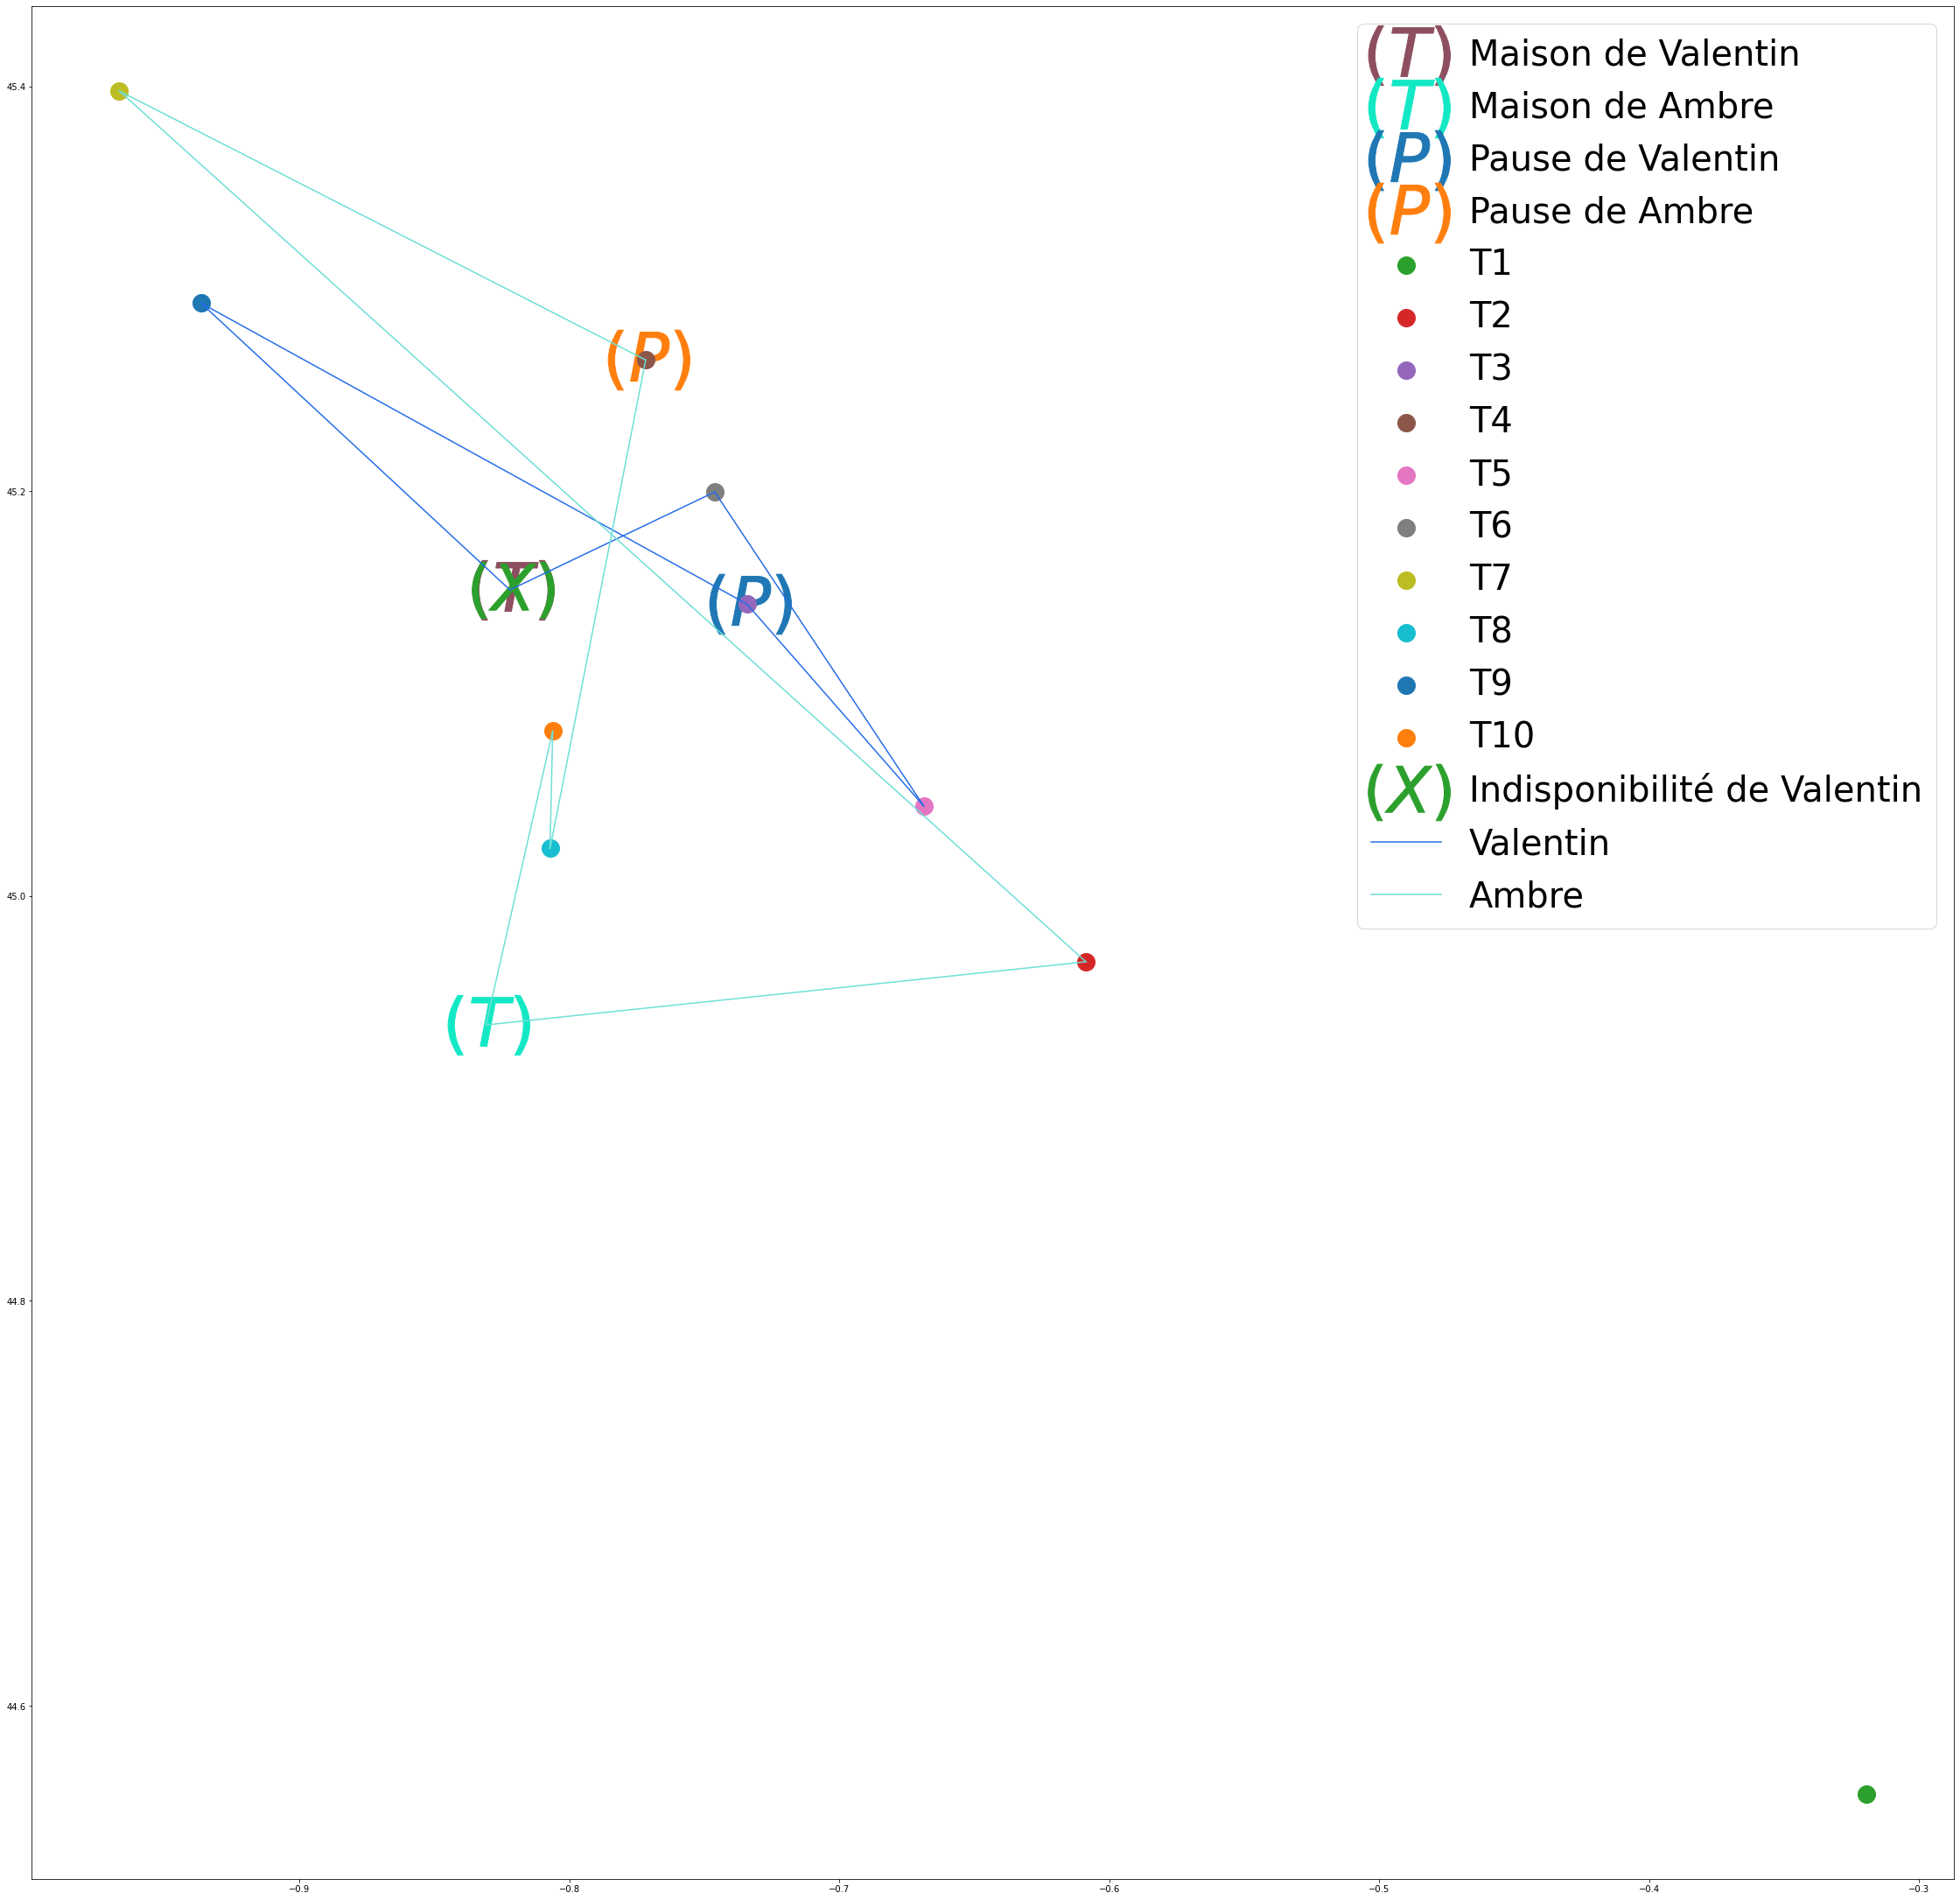

The total distance is 268.5277521892079 km(s).

Itération 2 :

Y[0] : [0, 4, 6, 7, 10, 12]
Y[1] : [1, 3, 5, 8, 9, 11]

0 -> 6
1 -> 11
3 -> 1
4 -> 7
5 -> 8
6 -> 4
7 -> 10
8 -> 3
9 -> 5
10 -> 12
11 -> 9
12 -> 0

B[0] = 480.0
B[1] = 480.0
B[2] = 1020.0
B[3] = 998.0
B[4] = 576.0
B[5] = 720.0
B[6] = 501.0
B[7] = 676.0
B[8] = 866.0
B[9] = 568.0
B[10] = 818.0
B[11] = 500.0
B[12] = 900.0

Le technicien 0 effectue sa pause au noeud 7 au temps 736.0 
Le technicien 1 effectue sa pause au noeud 5 au temps 780.0 
{0: 0, 1: 1, 3: 1, 4: 0, 5: 1, 6: 0, 7: 0, 8: 1, 9: 1, 10: 0, 11: 1, 12: 0}


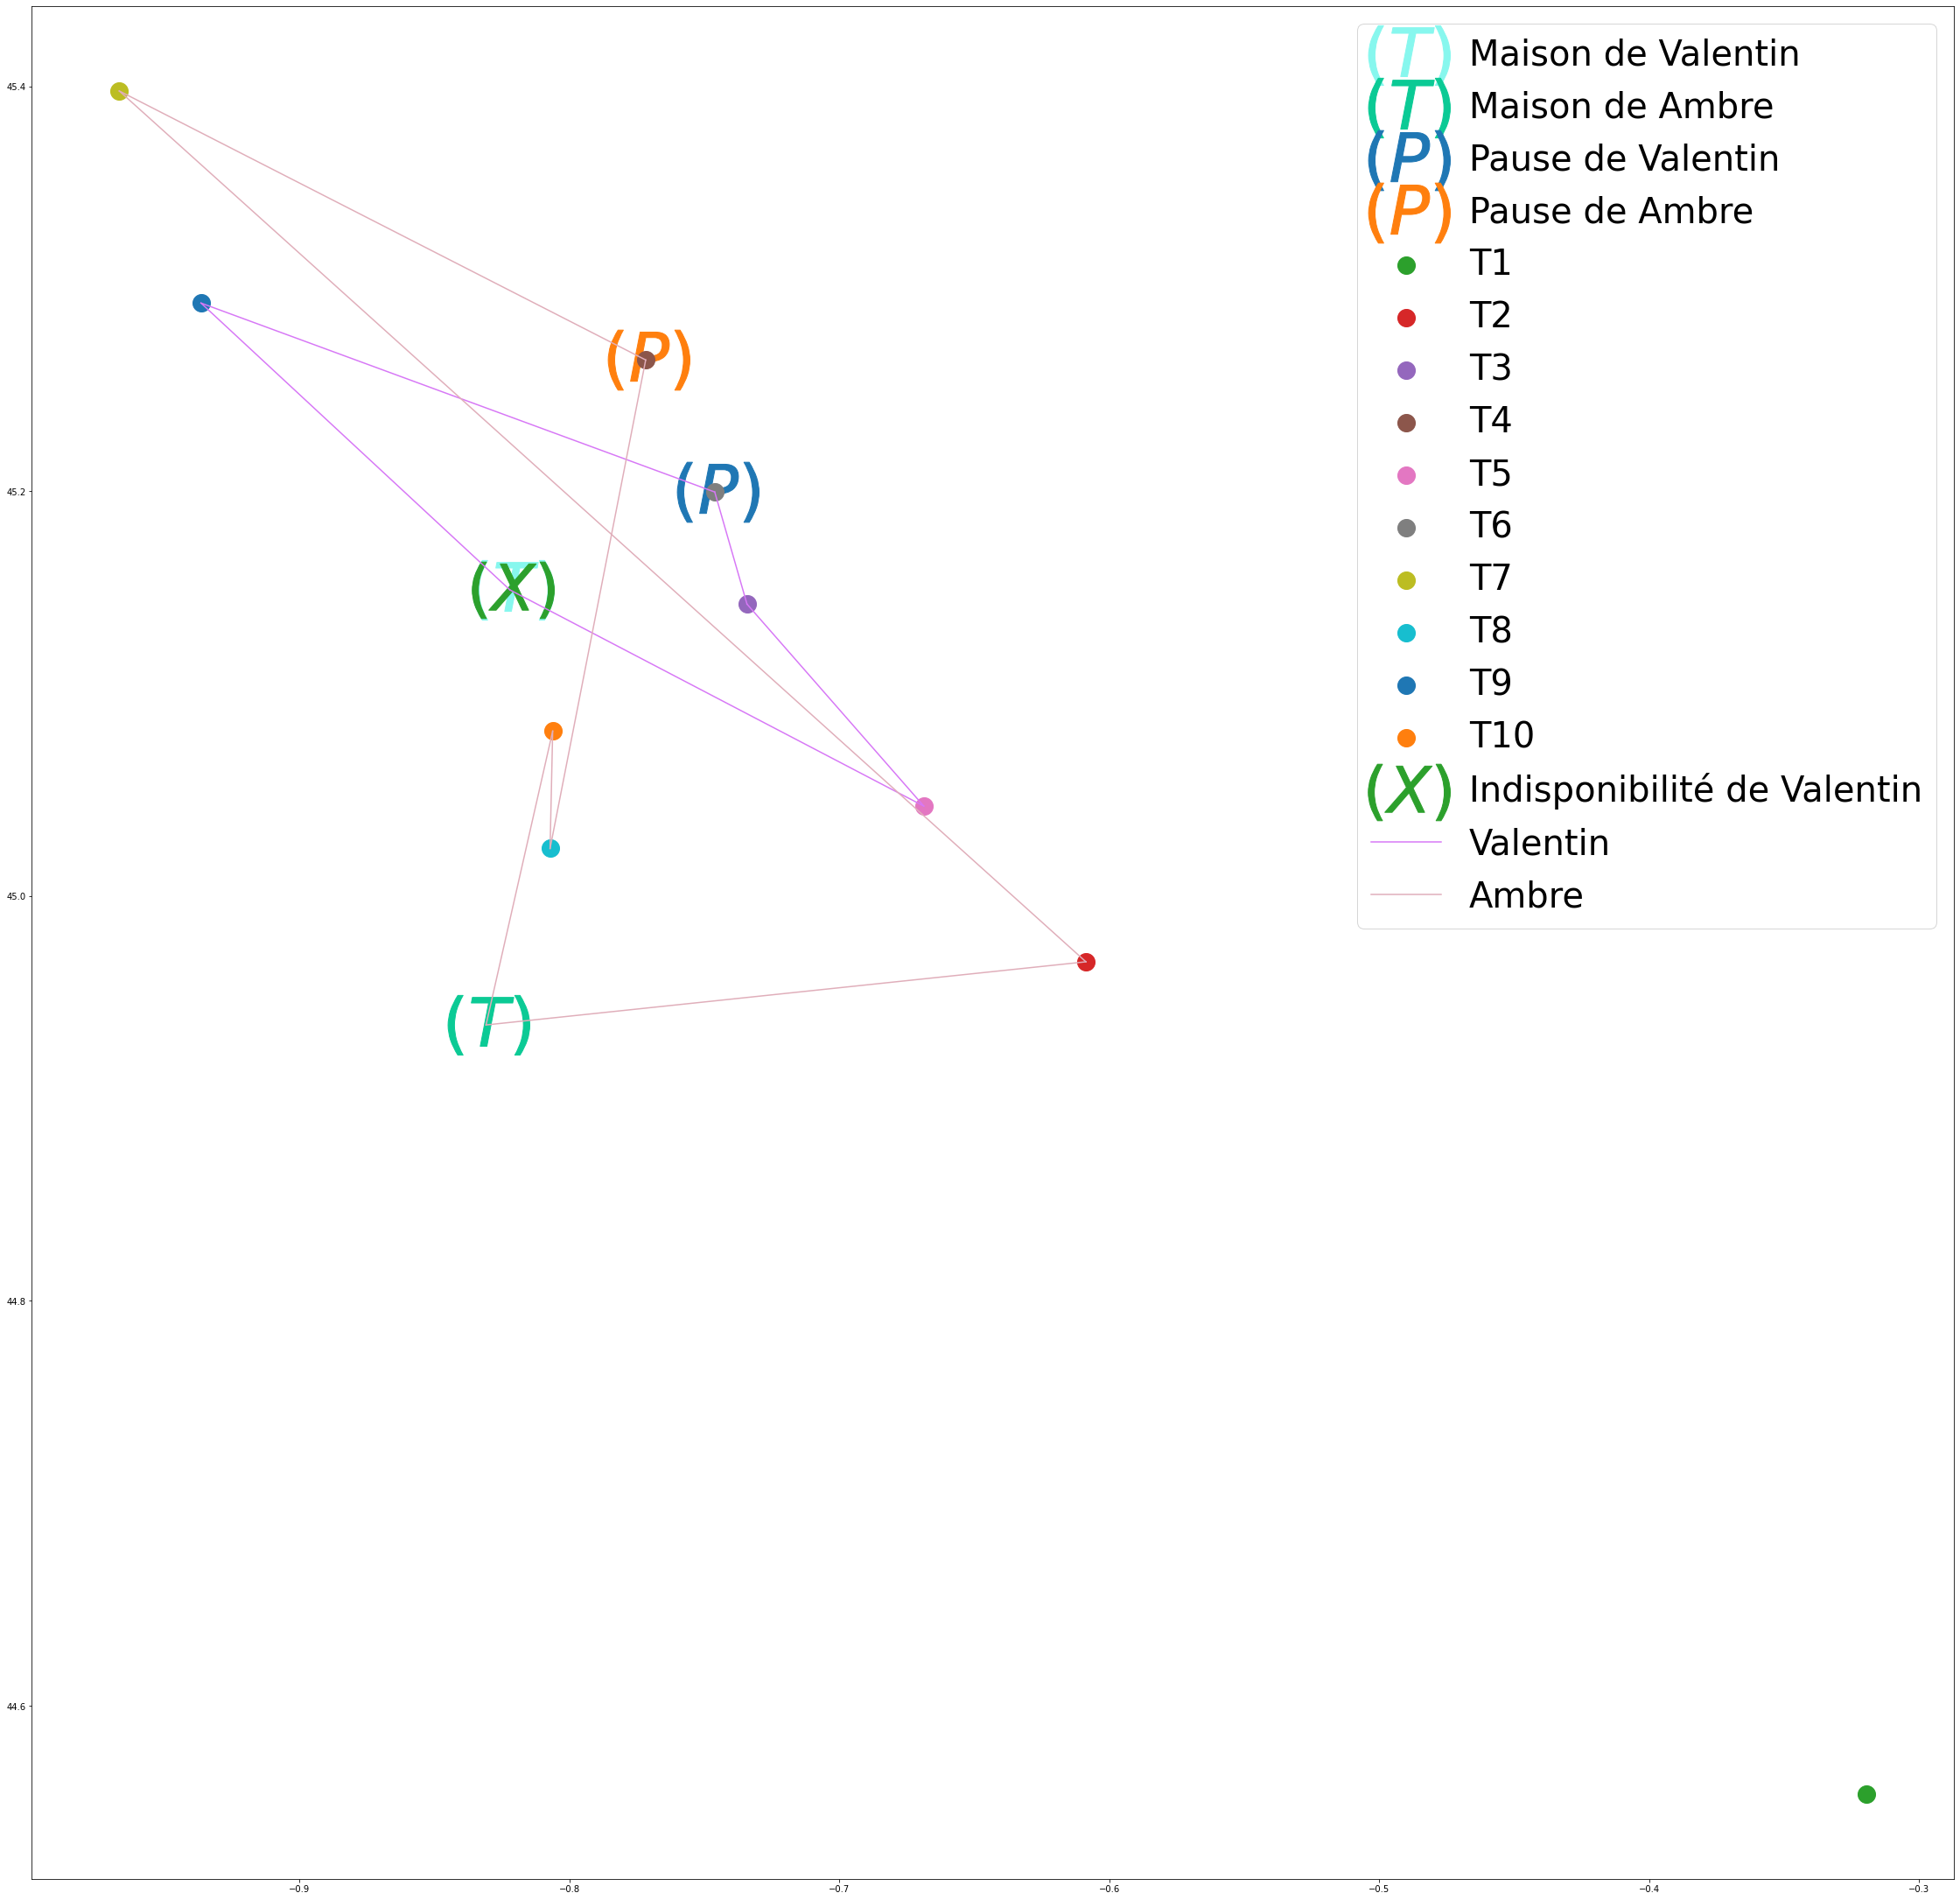

The total distance is 259.0280635528762 km(s).

Itération 3 :

Y[0] : [0, 4, 6, 7, 10, 12]
Y[1] : [1, 3, 5, 8, 9, 11]

0 -> 4
1 -> 3
3 -> 9
4 -> 6
5 -> 8
6 -> 7
7 -> 10
8 -> 11
9 -> 5
10 -> 12
11 -> 1
12 -> 0

B[0] = 480.0
B[1] = 480.0
B[2] = 480.0
B[3] = 540.0
B[4] = 489.0
B[5] = 714.0
B[6] = 564.0
B[7] = 676.0
B[8] = 895.0
B[9] = 621.0
B[10] = 818.0
B[11] = 1000.0
B[12] = 900.0

Le technicien 0 effectue sa pause au noeud 7 au temps 736.0 
Le technicien 1 effectue sa pause au noeud 5 au temps 774.0 
{0: 0, 1: 1, 3: 1, 4: 0, 5: 1, 6: 0, 7: 0, 8: 1, 9: 1, 10: 0, 11: 1, 12: 0}


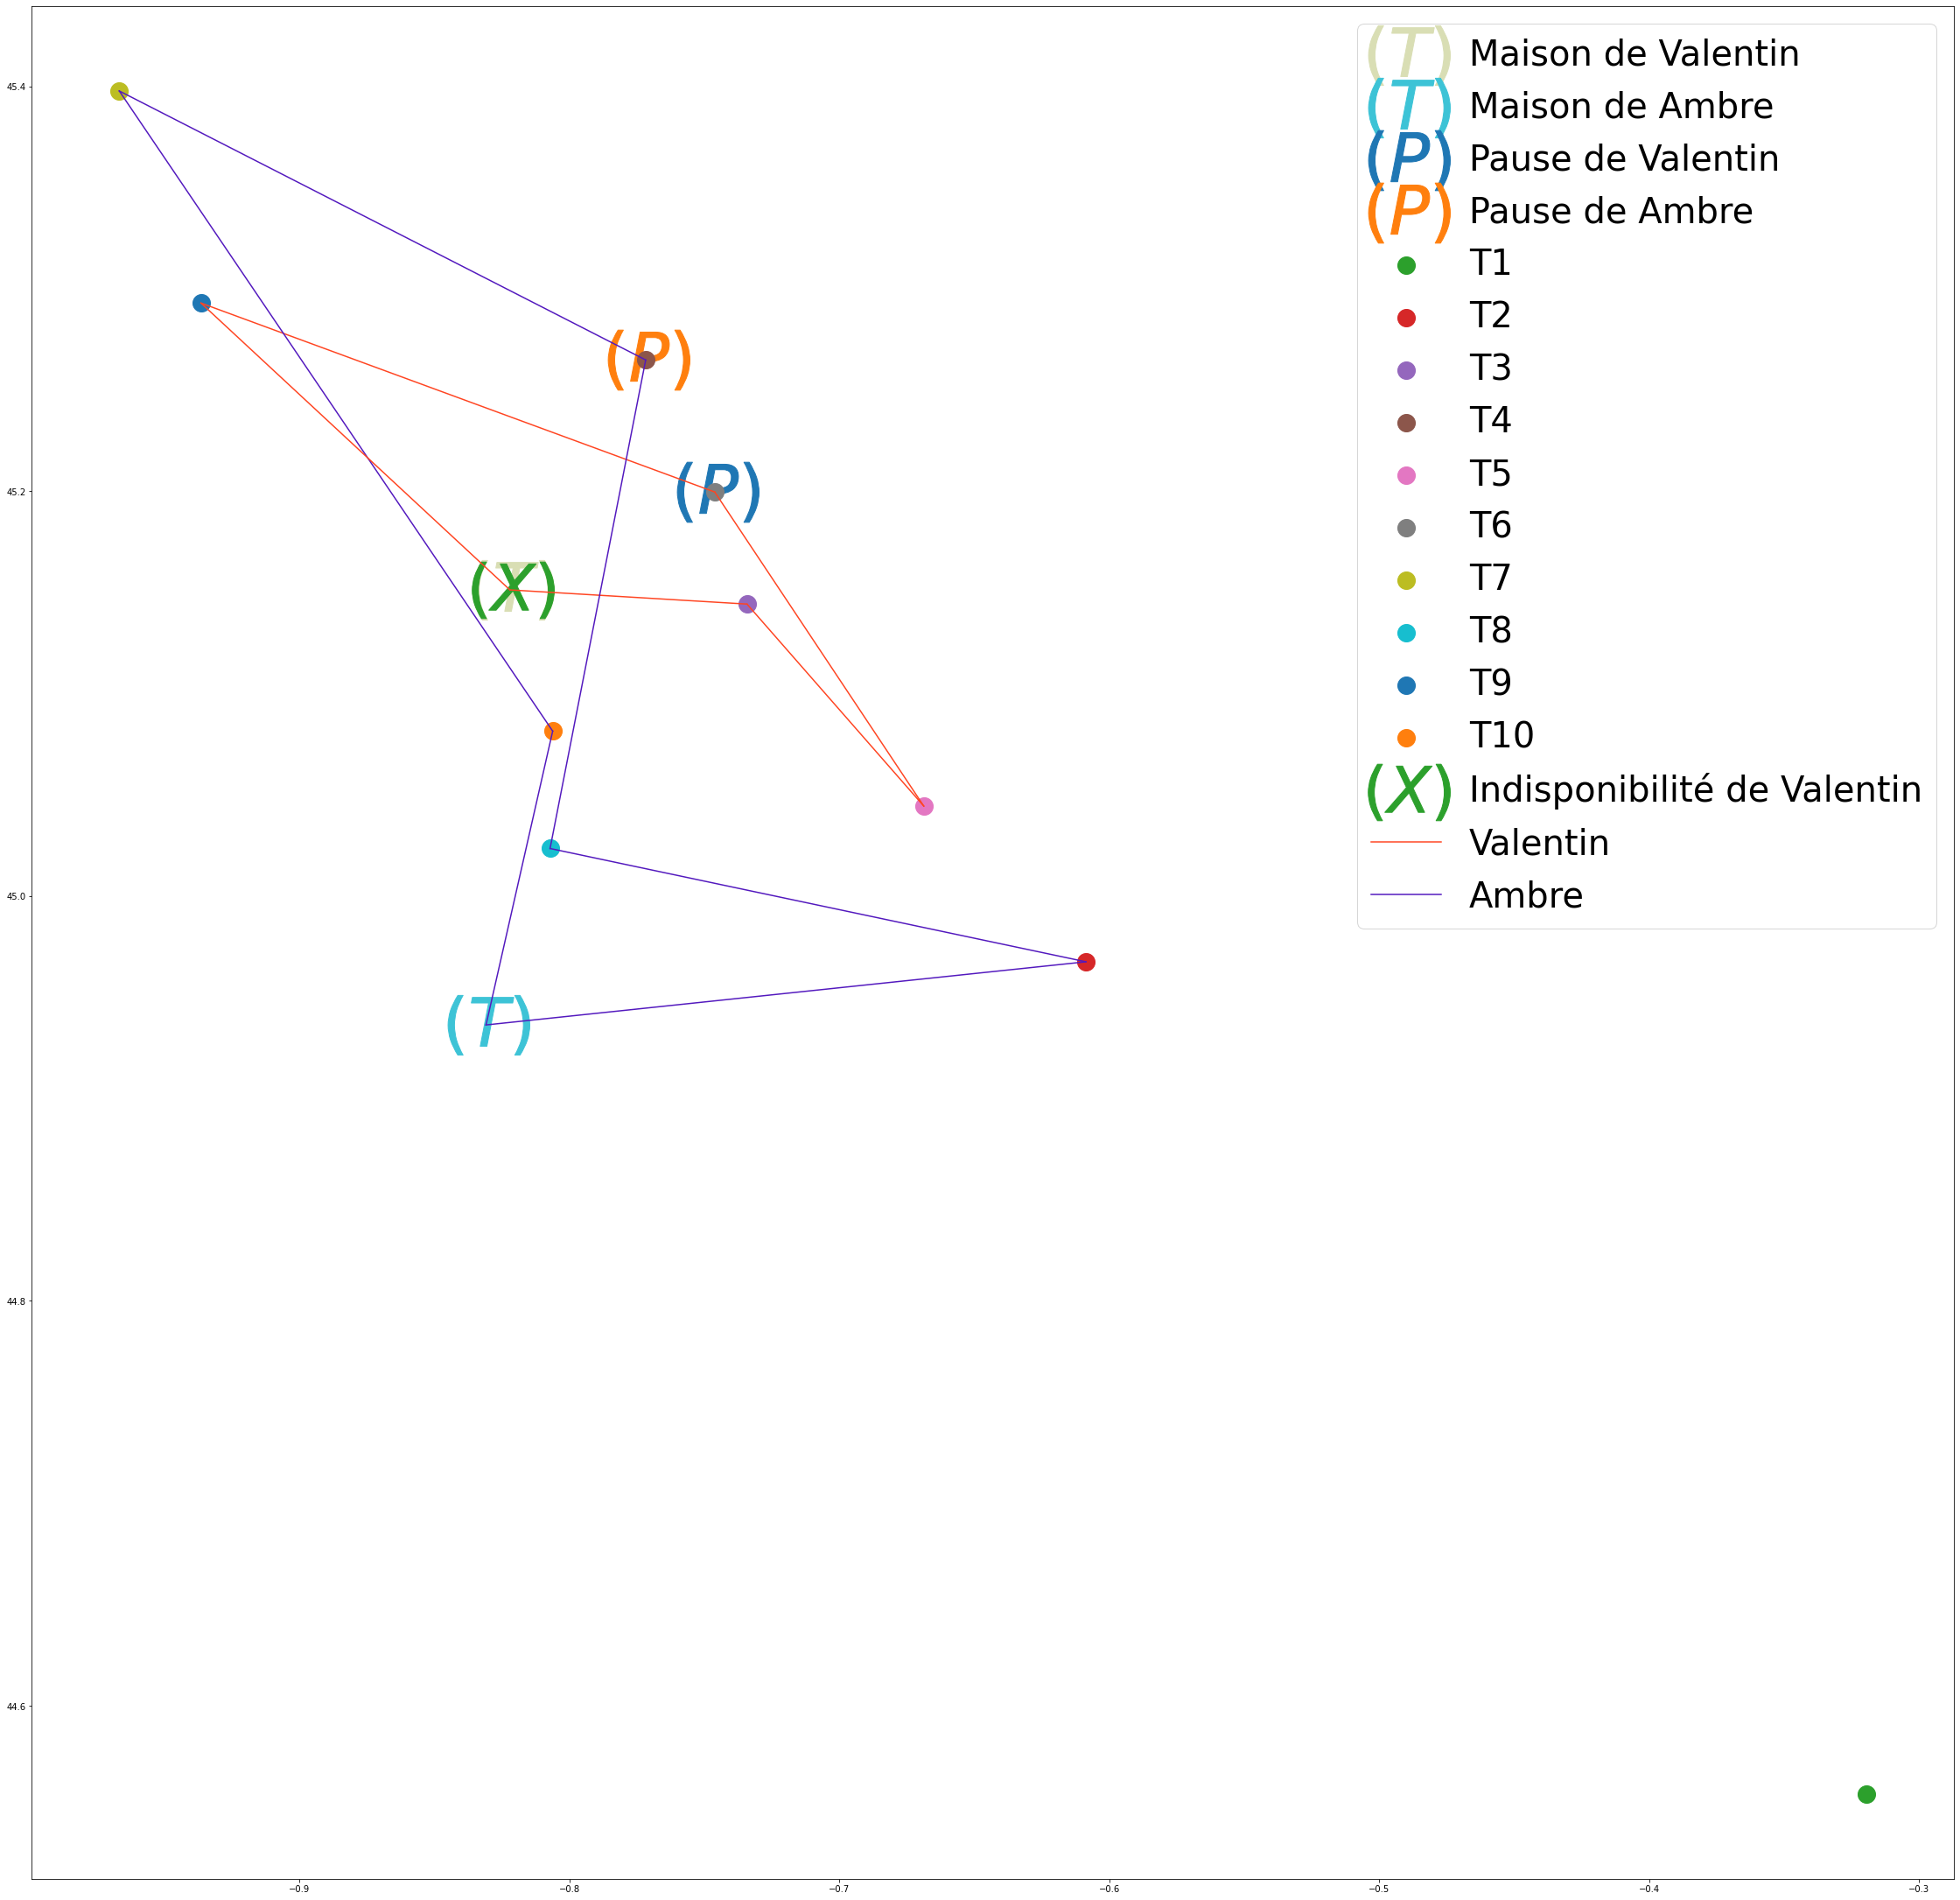

The total distance is 252.22208445647468 km(s).

Itération 4 :

Y[0] : [0, 4, 6, 7, 10, 12]
Y[1] : [1, 3, 5, 8, 9, 11]

0 -> 6
1 -> 9
3 -> 1
4 -> 10
5 -> 3
6 -> 4
7 -> 12
8 -> 5
9 -> 11
10 -> 7
11 -> 8
12 -> 0

B[0] = 480.0
B[1] = 480.0
B[2] = 480.0
B[3] = 998.0
B[4] = 576.0
B[5] = 895.0
B[6] = 501.0
B[7] = 830.0
B[8] = 720.0
B[9] = 492.0
B[10] = 688.0
B[11] = 560.0
B[12] = 900.0

Le technicien 0 effectue sa pause au noeud 10 au temps 748.0 
Le technicien 1 effectue sa pause au noeud 8 au temps 780.0 
{0: 0, 1: 1, 3: 1, 4: 0, 5: 1, 6: 0, 7: 0, 8: 1, 9: 1, 10: 0, 11: 1, 12: 0}


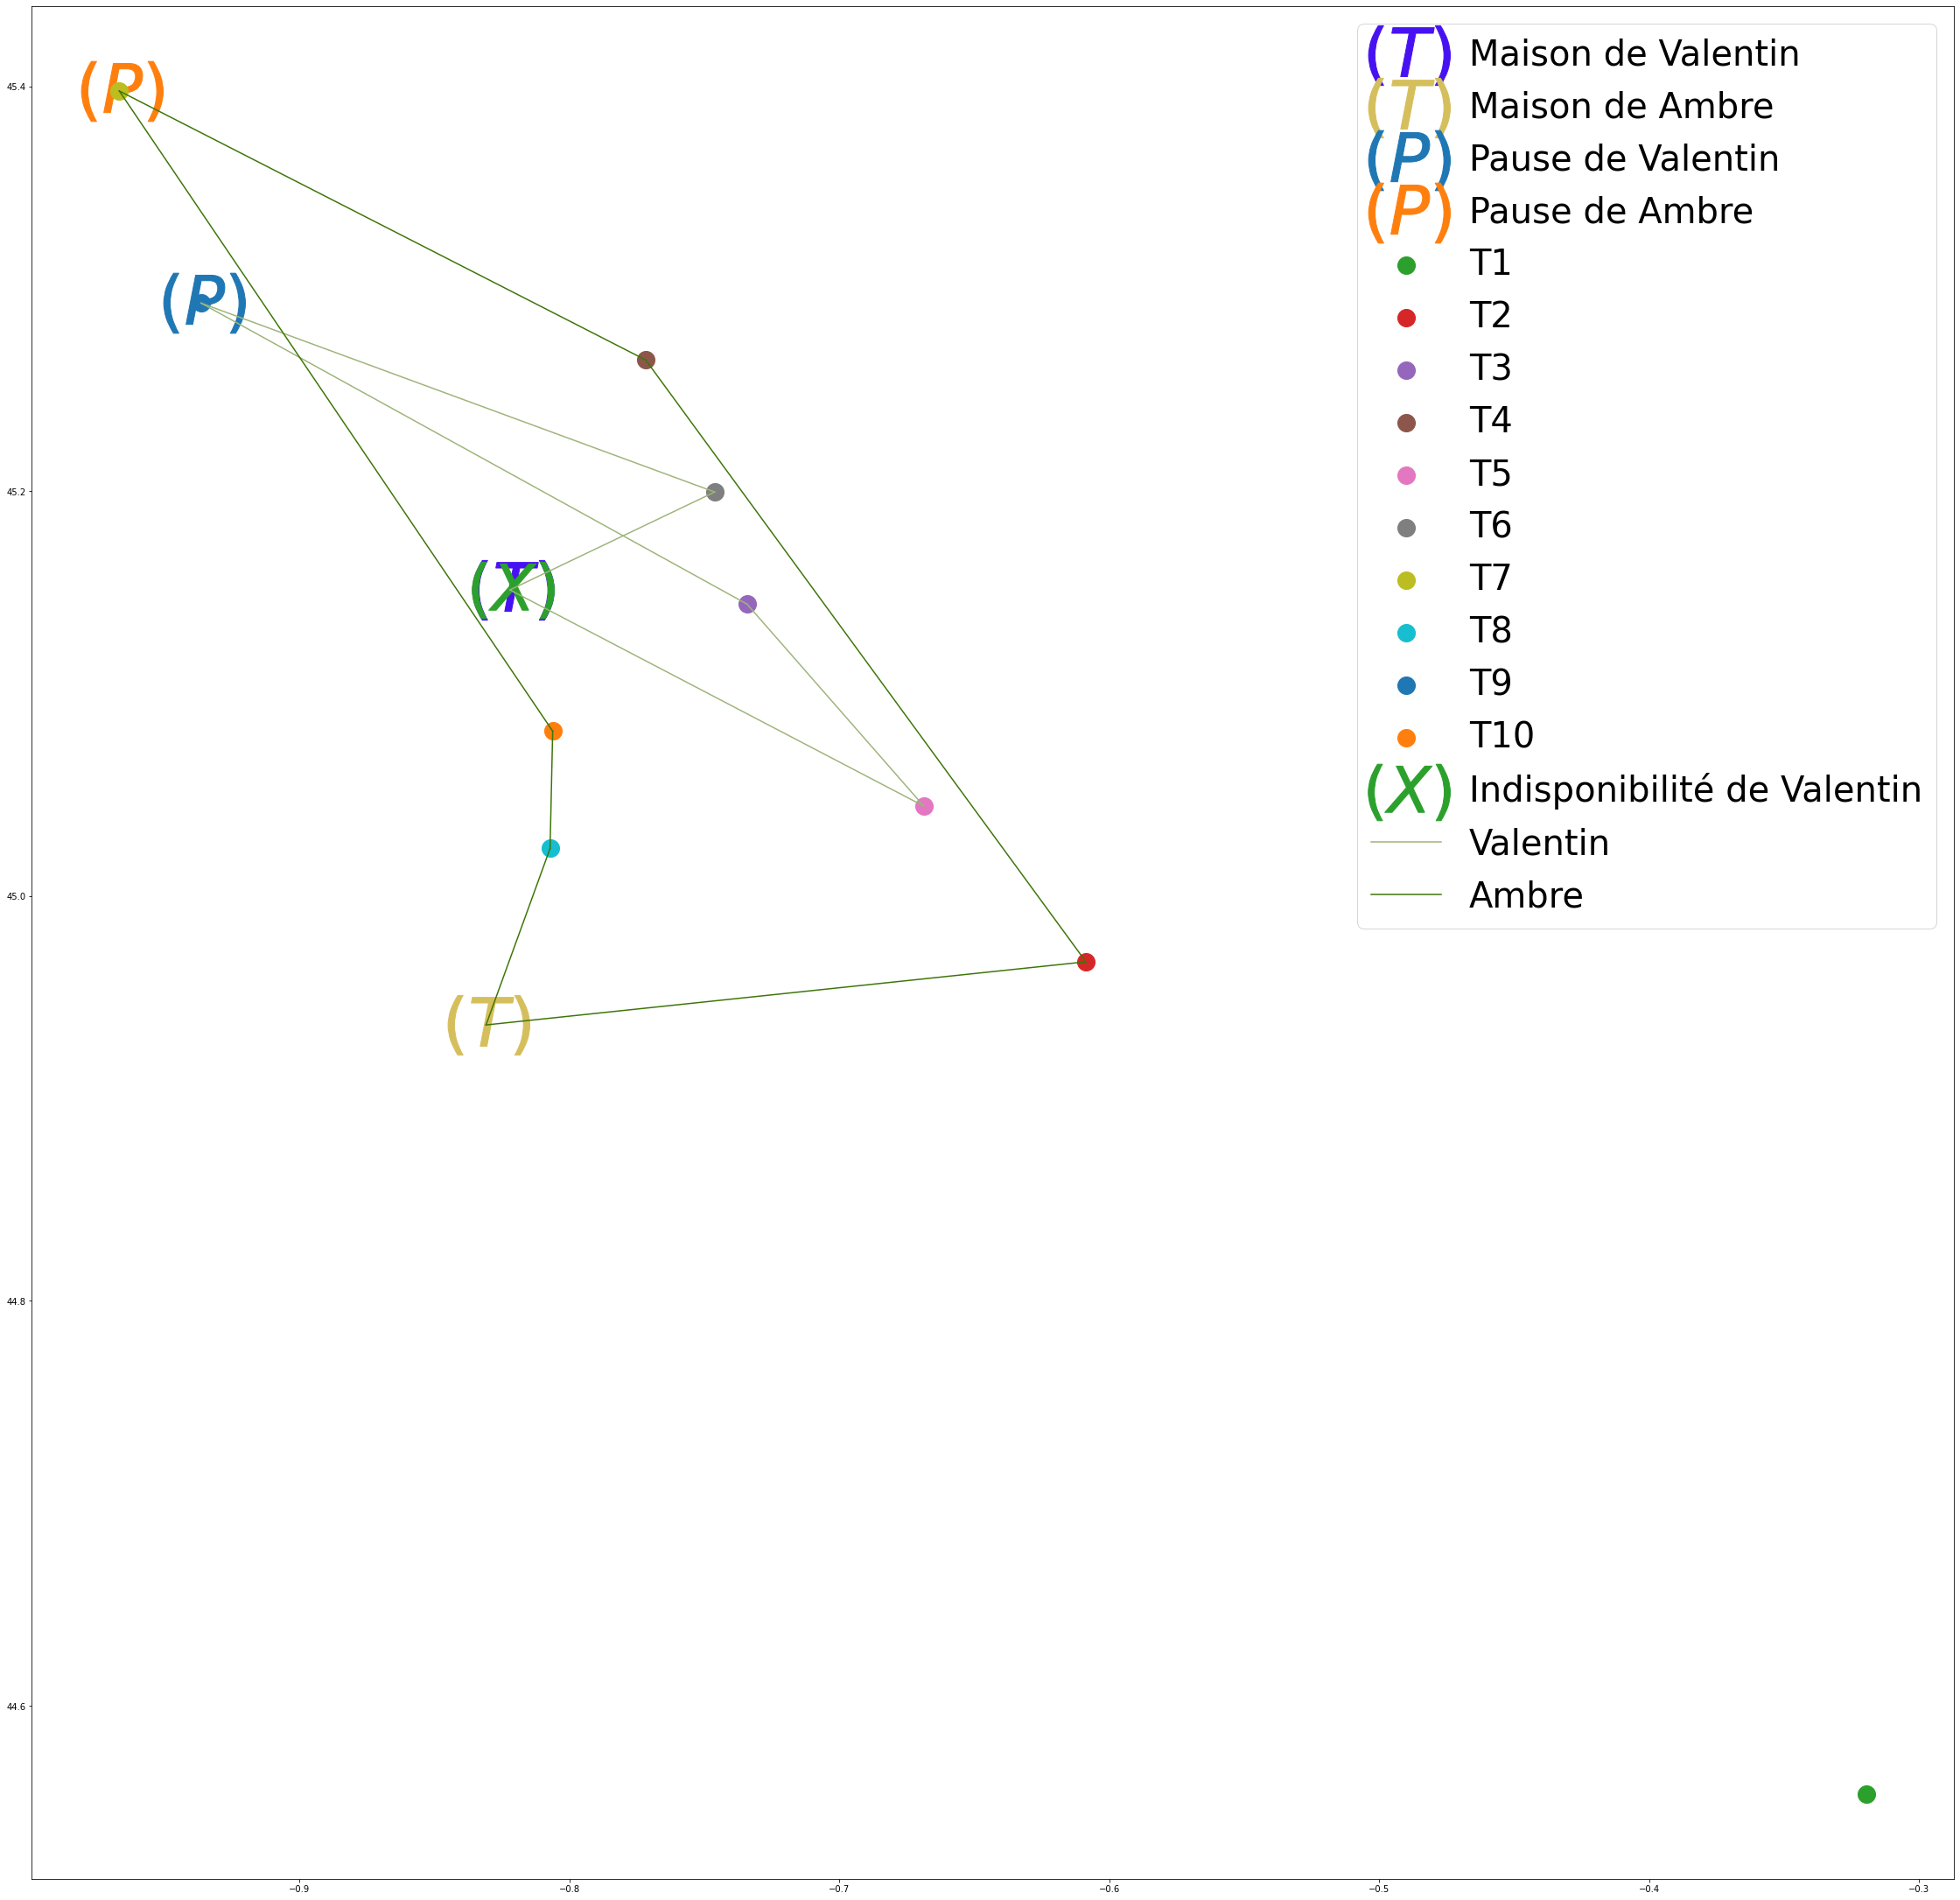

The total distance is 247.66679919472136 km(s).



In [24]:
epsi = 0.01
it = 1

m.params.outputflag = 0

m.update()

m.optimize()

data = []

while m.status != GRB.INFEASIBLE:
    
    print(f"Itération {it} :\n")
    it += 1
    
    for k in employees:
        print("Y[{}] : {}".format(k,[i for i in nodes if Y[(k,i)].x == 1]))
    print()
    for i in nodes:
        for j in nodes:
            if i != j and X[(i,j)].x == 1 :
                print(f"{i} -> {j}")
    print()
    for i in nodes:
        print(f"B[{i}] = {B[i].x}")

    print()

    #lunch_times associe l'heure de début de pause déjeuener pour l'employé k
    lunch_times = {}
    for k in employees:
        for i in nodes:
            if L[(k,i)].x == 1 :
                lunch_times[k] = B[i].x + Node.list[i].duration
                print(f"Le technicien {k} effectue sa pause au noeud {i} au temps {lunch_times[k]} ")
    
    # Z associe un indice de tâche à l'employé qui l'effectue
    Z = {}
    for i in nodes:
        for k in employees:
            if Y[(k,i)].x == 1:
                Z[i] = k
    print(Z)
    
    plot_map(Employee.list, Node.list, tasks, unavails, X, L, Z)
    store_result(path_result,Employee.list,tasks,lunch_times,Z,B)
    
    total_dist = quicksum([Node.distance[i,j]*X[(i,j)] for i in nodes for j in nodes if i != j])/Employee.speed
    print(f"The total distance is {total_dist.getValue()} km(s).\n")
    
    data.append((total_dist.getValue(), obj.getValue()))
    
    #----------#
    
    m.addConstr(total_dist <= total_dist.getValue() - epsi)
    
    m.update()

    m.optimize()

#### Affichons les solutions non-dominées obtenues

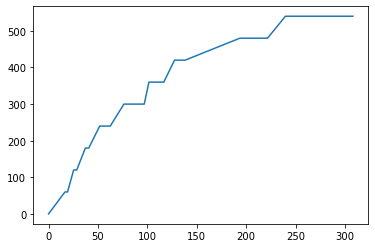

In [ ]:
x = np.array([dist for dist, _ in data])
y = np.array([duree for _, duree in data])

plt.plot(x, y)
plt.show()

In [ ]:
print(data)

[(308.05806019765043, 540.0), (275.2885740533105, 540.0), (264.28764541906315, 540.0), (248.97212731689672, 540.0), (248.31489072264378, 540.0), (246.17690752114962, 540.0), (239.7889339998372, 540.0), (221.58698098030106, 480.0), (218.30031526246108, 480.0), (209.2214302240191, 480.0), (207.61176371461522, 480.0), (205.5578863472858, 480.0), (202.82977353220514, 480.0), (193.5878365962804, 480.0), (138.18407824860344, 420.0), (136.2651037066037, 420.0), (127.51845268919054, 420.0), (116.63600027593665, 360.0), (115.89852066123358, 360.0), (114.47358775736961, 360.0), (105.98844253636852, 360.0), (101.58004122775922, 360.0), (96.85329526173912, 300.0), (90.13697805939127, 300.0), (79.78852527852513, 300.0), (79.01607181553067, 300.0), (78.75446915774346, 300.0), (76.26978126579102, 300.0), (62.48015700666002, 240.0), (57.1437544723577, 240.0), (52.70697328692704, 240.0), (51.77326947857679, 240.0), (40.69821941570184, 180.0), (37.29405429912591, 180.0), (28.518858225691254, 120.0), (25